In [63]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import os
import parkinson

import torch
from torch import nn
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, TopKPooling
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [65]:
SAVE_PATH = '../outputs/3_gnn'

# Processamento dos dados

In [66]:
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')

100%|██████████| 188/188 [00:03<00:00, 58.99it/s]


In [67]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data, return_upper_triangular=False)
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data, return_upper_triangular=False)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data, return_upper_triangular=False)

X = parkinson.utils.data.concatenate_data(control_correlation_matrix, parkinson_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(parkinson_data))], [2 for _ in range(len(prodomal_data))])
X_matrix, y = parkinson.utils.data.filter_data(X, y)

In [68]:
all_matrices = control_correlation_matrix + parkinson_correlation_matrix + prodomal_correlation_matrix
X_features = np.array(all_matrices)

-----------

### Computando OMST para todos os pacientes

In [69]:
Control_omst_graphs = []
if os.path.exists('../data/Control_OMSTs'):
    Control_omst_graphs = parkinson.graph.utils.load_graphs('../data/Control_OMSTs')
else:
    for i in tqdm(range(len(control_correlation_matrix))):
        adj = control_correlation_matrix[i].copy()
        omst_builder = parkinson.graph.OMSTBuilder(adj)
        omst_builder.build(verbose=False)
        Control_omst_graphs.append(omst_builder.final_graph.to_undirected())

100%|██████████| 66/66 [00:00<00:00, 812.07it/s]

Loaded 66 graphs from ../data/Control_OMSTs


In [70]:
Prodomal_omst_graphs = []
if os.path.exists('../data/Prodomal_OMSTs'):
    Prodomal_omst_graphs = parkinson.graph.utils.load_graphs('../data/Prodomal_OMSTs')
else:
    for i in tqdm(range(len(prodomal_correlation_matrix))):
        adj = prodomal_correlation_matrix[i].copy()
        omst_builder = parkinson.graph.OMSTBuilder(adj)
        omst_builder.build(verbose=False)
        Prodomal_omst_graphs.append(omst_builder.final_graph.to_undirected())

100%|██████████| 188/188 [00:00<00:00, 786.96it/s]

Loaded 188 graphs from ../data/Prodomal_OMSTs


In [71]:
Parkinson_omst_graphs = []
if os.path.exists('../data/Parkinson_OMSTs'):
    Parkinson_omst_graphs = parkinson.graph.utils.load_graphs('../data/Parkinson_OMSTs')
else:
    for i in tqdm(range(len(parkinson_correlation_matrix))):
        adj = parkinson_correlation_matrix[i].copy()
        omst_builder = parkinson.graph.OMSTBuilder(adj)
        omst_builder.build(verbose=False)
        Parkinson_omst_graphs.append(omst_builder.final_graph.to_undirected())

100%|██████████| 153/153 [00:00<00:00, 751.89it/s]

Loaded 153 graphs from ../data/Parkinson_OMSTs


### Construção das Node Features

Vamos usar a abordagem 'Connection Profile'. Um "connection profile" para um nó simples (um ROI) é seu padrão único de conectividade com os outros nós do cérebro. Em termos práticos, corresponde a uma linha (ou coluna, pois a matriz é simétrica) da matriz de conectividade fncional.

In [72]:
def to_pyg_data(graph: nx.Graph, feature_matrix: np.ndarray, label: int) -> Data:
    """Converts a NetworkX graph and features into a PyTorch Geometric Data object."""
    x = torch.tensor(feature_matrix, dtype=torch.float)

    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

    edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float)

    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# --- Create the PyG dataset ---
pyg_dataset = []
for i, graph in enumerate(tqdm(Control_omst_graphs + Prodomal_omst_graphs + Parkinson_omst_graphs, desc="Creating PyG Data Objects")):
    pyg_data_point = to_pyg_data(graph, X_features[i], y[i])
    pyg_dataset.append(pyg_data_point)

Creating PyG Data Objects: 100%|██████████| 407/407 [00:00<00:00, 1607.91it/s]


------

### Construindo a GNN

In [73]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.4):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

# Treinamento

In [74]:
# --- Training & Evaluation Functions ---
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    # CORRECTED LOOP: Iterate over a single 'batch' object
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, num_classes=3):
    model.eval()
    logits_list, y_true_list = [], []
    # CORRECTED LOOP
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        logits_list.append(logits.cpu())
        y_true_list.append(batch.y.cpu())

    y_pred_logits = torch.cat(logits_list)
    y_true = torch.cat(y_true_list)
    probs = F.softmax(y_pred_logits, dim=1).numpy()
    preds = y_pred_logits.argmax(dim=1).numpy()

    # Calculate metrics
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, average='weighted', zero_division=0)
    true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc = roc_auc_score(true_bin, probs, multi_class='ovr', average='weighted')
    return acc, f1, auc, y_true.numpy(), preds

In [75]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 3
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 10

In [76]:
X_trainval, X_test, y_trainval, y_test = train_test_split(pyg_dataset, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

# Weighted sampler para lidar com desbalanceamento
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in y_train])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(X_train, batch_size=32, sampler=sampler)
val_loader = DataLoader(X_val, batch_size=32, shuffle=False)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)


In [77]:
model = GCNNet(
    in_channels=pyg_dataset[0].num_node_features,
    hidden_channels=16, # Hyperparameter to tune
    num_classes=NUM_CLASSES,
    dropout=0.4 # Hyperparameter to tune
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss()

best_val_auc = 0
patience_counter = 0
os.makedirs('../weights/3_gnn_corrected/', exist_ok=True)
model_save_path = '../weights/3_gnn_corrected/best_model.pt'

print(f"--- Starting Training on {DEVICE} ---")
for epoch in range(1, EPOCHS + 1):
    loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_acc, val_f1, val_auc, _, _ = evaluate(model, val_loader, DEVICE)

    print(f"Epoch: {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> New best model saved with Val AUC: {best_val_auc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"--- Early stopping triggered after {epoch} epochs. ---")
            break

print("\n--- Training Finished ---")

--- Starting Training on cuda ---


ValueError: Input contains NaN.


--- Evaluating on Test Set ---

Test Accuracy: 0.1585
Test F1-Score (Weighted): 0.0434
Test ROC-AUC (Weighted OVR): 0.3899

Classification Report:
              precision    recall  f1-score   support

     Control       0.16      1.00      0.27        13
   Prodromal       0.00      0.00      0.00        31
 Parkinson's       0.00      0.00      0.00        38

    accuracy                           0.16        82
   macro avg       0.05      0.33      0.09        82
weighted avg       0.03      0.16      0.04        82

Confusion Matrix:


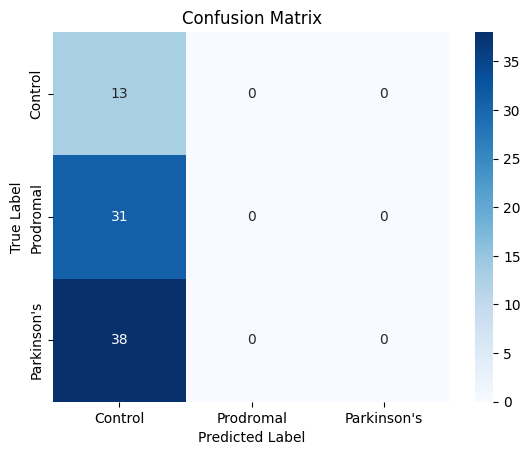

In [78]:

# --- Final Evaluation on the Test Set ---
print("\n--- Evaluating on Test Set ---")
model.load_state_dict(torch.load(model_save_path))
test_acc, test_f1, test_auc, y_true, y_pred = evaluate(model, test_loader, DEVICE)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1-Score (Weighted): {test_f1:.4f}")
print(f"Test ROC-AUC (Weighted OVR): {test_auc:.4f}")

# --- Classification Report and Confusion Matrix ---
target_names = ['Control', 'Prodromal', 'Parkinson\'s']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()